<a href="https://colab.research.google.com/github/taras-musakovskyi/colab-jupyter-fish-models/blob/main/Stable_Diffusion_1_5_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python3
"""
Stable Diffusion 1.5 LoRA Training for Unconditional Fish Generation (Point 1a)
Dataset: 12,301 fish images - uploaded as ZIP from local machine
Training: Google Colab with diffusers library
Models: Periodic upload to Google Drive
"""

# ============================================================================
# CELL 1: Environment Setup & Installation
# ============================================================================
!pip install -q diffusers transformers accelerate bitsandbytes safetensors xformers
!pip install -q torch torchvision --upgrade
!pip install -q peft huggingface_hub

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import json
import zipfile
import shutil
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
import numpy as np
from dataclasses import dataclass
from typing import Optional, List
import time

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 10.7 MB/s eta 0:00:00
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
VRAM: 39.56 GB


In [ ]:
# ============================================================================
# CELL 2: Google Drive Authentication (for uploading results only)
# ============================================================================
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseUpload
import io

print("🔐 Authenticating with Google Drive for results upload...")

# Use Colab's built-in authentication
auth.authenticate_user()
from google.auth import default
creds, _ = default()

# Build Drive service
drive_service = build('drive', 'v3', credentials=creds)

print("✓ Authentication successful!")

# Set your results upload folder ID
# Get this by opening the target folder in Drive and copying the ID from URL
# Example: https://drive.google.com/drive/folders/1AbC123XyZ
GDRIVE_RESULTS_FOLDER_ID = "1-cCnvC2Y_7OPA2_lwDCuTFqHNMCXD-Xj"  # Replace with actual folder ID

# Verify folder ID is set
if "YOUR_" in GDRIVE_RESULTS_FOLDER_ID or "_HERE" in GDRIVE_RESULTS_FOLDER_ID:
    print("\n⚠️  WARNING: Set GDRIVE_RESULTS_FOLDER_ID to upload results!")
    print("   1. Create a folder in Google Drive")
    print("   2. Copy the folder ID from the URL")
    print("   3. Update GDRIVE_RESULTS_FOLDER_ID above")
else:
    print(f"✓ Results will be uploaded to folder ID: {GDRIVE_RESULTS_FOLDER_ID}")

🔐 Authenticating with Google Drive for results upload...
✓ Authentication successful!
✓ Results will be uploaded to folder ID: 1-cCnvC2Y_7OPA2_lwDCuTFqHNMCXD-Xj


In [ ]:

# ============================================================================
# CELL 3: Upload and Extract Dataset from Local Machine
# ============================================================================
from google.colab import files

LOCAL_DATA_DIR = '/content/fish_dataset'

print("📤 Upload your dataset ZIP file from local machine")
print("   Expected file: FishCropsFromYolo.zip")
print("   This will open a file picker - select your ZIP file\n")

# Upload file from local machine
uploaded = files.upload()

# Get the uploaded filename
zip_filename = list(uploaded.keys())[0]
print(f"\n✓ Upload complete: {zip_filename}")
print(f"   Size: {len(uploaded[zip_filename]) / (1024**2):.2f} MB")

# Extract the ZIP file
print(f"\n📦 Extracting {zip_filename}...")
zip_path = f'/content/{zip_filename}'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/fish_dataset_temp')

print("✓ Extraction complete")

# Find the extracted folders and organize them
print("\n📁 Organizing dataset structure...")

extracted_root = '/content/fish_dataset_temp'
extracted_contents = os.listdir(extracted_root)

print(f"   Found: {extracted_contents}")

# Create organized structure
os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

# Move folders to proper location
for item in extracted_contents:
    item_path = os.path.join(extracted_root, item)
    if os.path.isdir(item_path) and item.lower() in ['small', 'medium', 'wide']:
        dest_path = os.path.join(LOCAL_DATA_DIR, item.lower())
        if os.path.exists(dest_path):
            shutil.rmtree(dest_path)
        shutil.move(item_path, dest_path)
        print(f"   ✓ Moved {item} → {dest_path}")

# Count images in each folder
print(f"\n📊 Dataset Summary:")
total_images = 0
for size_cat in ['small', 'medium', 'wide']:
    folder_path = os.path.join(LOCAL_DATA_DIR, size_cat)
    if os.path.exists(folder_path):
        images = [f for f in os.listdir(folder_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        count = len(images)
        total_images += count
        print(f"   {size_cat}: {count} images")
    else:
        print(f"   ⚠️  {size_cat}: folder not found")

print(f"\n✓ Total images loaded: {total_images}")
print(f"✓ Dataset ready at: {LOCAL_DATA_DIR}")

# Cleanup
shutil.rmtree(extracted_root)
os.remove(zip_path)
print("\n🧹 Cleaned up temporary files")

📤 Upload your dataset ZIP file from local machine
   Expected file: FishCropsFromYolo.zip
   This will open a file picker - select your ZIP file



Saving FishCropsFromYoloCleanedLocally.zip to FishCropsFromYoloCleanedLocally.zip

✓ Upload complete: FishCropsFromYoloCleanedLocally.zip
   Size: 292.86 MB

📦 Extracting FishCropsFromYoloCleanedLocally.zip...
✓ Extraction complete

📁 Organizing dataset structure...
   Found: ['__MACOSX', 'wide', 'small', 'medium']
   ✓ Moved wide → /content/fish_dataset/wide
   ✓ Moved small → /content/fish_dataset/small
   ✓ Moved medium → /content/fish_dataset/medium

📊 Dataset Summary:
   small: 2292 images
   medium: 4835 images
   wide: 4133 images

✓ Total images loaded: 11260
✓ Dataset ready at: /content/fish_dataset

🧹 Cleaned up temporary files


In [ ]:
# ============================================================================
# CELL 4: Configuration
# ============================================================================
@dataclass
class TrainingConfig:
    """Configuration for SD 1.5 LoRA training"""
    # Model settings
    pretrained_model_name: str = "runwayml/stable-diffusion-v1-5"
    resolution: int = 512  # SD 1.5 native resolution

    # LoRA settings
    lora_rank: int = 16  # Rank of LoRA matrices (4, 8, 16, 32)
    lora_alpha: int = 32  # Scaling factor (usually 2x rank)
    lora_dropout: float = 0.1

    # Training hyperparameters
    num_epochs: int = 50
    batch_size: int = 32  # Adjust based on VRAM - 32 for a100
    gradient_accumulation_steps: int = 2  # Effective batch still = 16*2 = 32
    learning_rate: float = 1e-4
    lr_scheduler: str = "cosine"  # "constant", "linear", "cosine"
    warmup_steps: int = 500

    # Optimization
    use_8bit_adam: bool = True  # Saves VRAM
    mixed_precision: str = "fp16"  # "no", "fp16", "bf16"
    gradient_checkpointing: bool = True

    # Data augmentation (minimal for fish realism)
    center_crop: bool = True
    random_flip: bool = True

    # Logging & checkpointing
    save_every_n_epochs: int = 5
    validation_every_n_epochs: int = 5
    num_validation_images: int = 4

    # Periodic GDrive upload settings
    upload_after_epoch: int = 15  # Don't upload during first 25 epochs
    upload_interval_epochs: int = 5  # Upload every 5 epochs after threshold

    # Unconditional training (Point 1a)
    use_captions: bool = False  # Set True for Point 1b
    default_prompt: str = "a fish in aquarium"  # Generic prompt for unconditional

    # Dataset paths
    dataset_root: str = LOCAL_DATA_DIR
    output_dir: str = "/content/sd_lora_outputs"

config = TrainingConfig()

# Create output directories
os.makedirs(config.output_dir, exist_ok=True)
os.makedirs(f"{config.output_dir}/checkpoints", exist_ok=True)
os.makedirs(f"{config.output_dir}/samples", exist_ok=True)

print("Configuration loaded:")
print(f"  Model: {config.pretrained_model_name}")
print(f"  LoRA rank: {config.lora_rank}, alpha: {config.lora_alpha}")
print(f"  Resolution: {config.resolution}x{config.resolution}")
print(f"  Batch size: {config.batch_size}, Gradient accum: {config.gradient_accumulation_steps}")
print(f"  Effective batch: {config.batch_size * config.gradient_accumulation_steps}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  Epochs: {config.num_epochs}")
print(f"  Upload to GDrive: After epoch {config.upload_after_epoch}, every {config.upload_interval_epochs} epochs")


Configuration loaded:
  Model: runwayml/stable-diffusion-v1-5
  LoRA rank: 16, alpha: 32
  Resolution: 512x512
  Batch size: 32, Gradient accum: 2
  Effective batch: 64
  Learning rate: 0.0001
  Epochs: 50
  Upload to GDrive: After epoch 25, every 5 epochs


In [ ]:
# ============================================================================
# CELL 5: Dataset Class
# ============================================================================
class FishDataset(Dataset):
    """Dataset for fish images from small/medium/wide folders"""

    def __init__(self, root_dir: str, resolution: int = 512,
                 center_crop: bool = True, random_flip: bool = True,
                 use_captions: bool = False, default_prompt: str = "a fish"):
        self.root_dir = Path(root_dir)
        self.resolution = resolution
        self.use_captions = use_captions
        self.default_prompt = default_prompt

        # Collect all image paths from small/medium/wide folders
        self.image_paths = []
        for folder in ["small", "medium", "wide"]:
            folder_path = self.root_dir / folder
            if folder_path.exists():
                self.image_paths.extend(
                    list(folder_path.glob("*.jpg")) +
                    list(folder_path.glob("*.png"))
                )

        print(f"Found {len(self.image_paths)} images")

        # Build transforms
        transform_list = []
        if center_crop:
            transform_list.append(transforms.CenterCrop(min(resolution, resolution)))
        transform_list.extend([
            transforms.Resize((resolution, resolution), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # [-1, 1] range for SD
        ])
        if random_flip:
            transform_list.insert(0, transforms.RandomHorizontalFlip(p=0.5))

        self.transform = transforms.Compose(transform_list)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.transform(image)

        # Point 1a: unconditional, use default prompt
        caption = self.default_prompt

        return {
            "pixel_values": pixel_values,
            "input_ids": caption,  # Will be tokenized in collate_fn
        }


In [ ]:
# ============================================================================
# CELL 6: Load Models & Setup LoRA
# ============================================================================
from diffusers import (
    StableDiffusionPipeline,
    UNet2DConditionModel,
    DDPMScheduler,
    AutoencoderKL
)
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
import bitsandbytes as bnb

print("Loading Stable Diffusion 1.5 models...")

tokenizer = CLIPTokenizer.from_pretrained(
    config.pretrained_model_name,
    subfolder="tokenizer"
)

text_encoder = CLIPTextModel.from_pretrained(
    config.pretrained_model_name,
    subfolder="text_encoder"
)

vae = AutoencoderKL.from_pretrained(
    config.pretrained_model_name,
    subfolder="vae"
)

unet = UNet2DConditionModel.from_pretrained(
    config.pretrained_model_name,
    subfolder="unet"
)

noise_scheduler = DDPMScheduler.from_pretrained(
    config.pretrained_model_name,
    subfolder="scheduler"
)

print("✓ Models loaded")

# Freeze VAE and text encoder (only train UNet with LoRA)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Enable gradient checkpointing for memory efficiency
if config.gradient_checkpointing:
    unet.enable_gradient_checkpointing()

# Setup LoRA on UNet
lora_config = LoraConfig(
    r=config.lora_rank,
    lora_alpha=config.lora_alpha,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],  # Attention layers
    lora_dropout=config.lora_dropout,
)

unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)
text_encoder.to(device)
unet.to(device)

print(f"✓ Models moved to {device}")

Loading Stable Diffusion 1.5 models...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

✓ Models loaded
trainable params: 3,188,736 || all params: 862,709,700 || trainable%: 0.3696
✓ Models moved to cuda


In [ ]:
# ============================================================================
# CELL 9: Training Loop with Periodic GDrive Upload
# ============================================================================
from accelerate import Accelerator

def upload_best_model_to_gdrive(epoch, best_model_path, max_retries=3):
    """Upload best LoRA weights to Google Drive with retry logic"""
    for attempt in range(max_retries):
        try:
            print(f"\n📤 Uploading best model to Google Drive (attempt {attempt+1}/{max_retries})...")

            if not os.path.exists(best_model_path):
                print("⚠️ Best model not found, skipping upload")
                return False

            # Load checkpoint to get actual epoch number
            try:
                checkpoint = torch.load(best_model_path, map_location='cpu')
                actual_epoch = checkpoint.get('epoch', epoch)
            except:
                actual_epoch = epoch

            # Create timestamped filename with actual best epoch
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            remote_filename = f'lora_best_epoch_{actual_epoch}_{timestamp}.safetensors'

            file_metadata = {
                'name'p: remote_filename,
                'parents': [GDRIVE_RESULTS_FOLDER_ID]
            }

            with open(best_model_path, 'rb') as f:
                media = MediaIoBaseUpload(
                    io.BytesIO(f.read()),
                    mimetype='application/octet-stream',
                    resumable=True
                )

            drive_service.files().create(
                body=file_metadata,
                media_body=media,
                fields='id'
            ).execute()

            print(f"✅ Best model uploaded: {remote_filename}")
            return True

        except Exception as e:
            print(f"⚠️ Upload attempt {attempt+1} failed: {e}")
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt  # Exponential backoff: 1s, 2s, 4s
                print(f"   Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print(f"❌ Upload failed after {max_retries} attempts")
                return False

# Setup accelerator for mixed precision training
accelerator = Accelerator(
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

# Prepare for training
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

# Training state
global_step = 0
best_loss = float('inf')
best_model_path = f"{config.output_dir}/checkpoints/lora_best.safetensors"
last_uploaded_epoch = 0

print("="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(config.num_epochs):
    unet.train()
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{config.num_epochs}")

    for step, batch in enumerate(progress_bar):
        with accelerator.accumulate(unet):
            # Move batch to device
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)

            # Encode images to latent space
            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

            # Sample noise
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]

            # Sample random timesteps
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (bsz,), device=device
            ).long()

            # Add noise to latents
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get text embeddings
            with torch.no_grad():
                encoder_hidden_states = text_encoder(input_ids)[0]

            # Predict noise
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # Calculate loss (MSE between predicted and actual noise)
            loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

            # Backpropagation
            accelerator.backward(loss)

            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), 1.0)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Logging
        if accelerator.sync_gradients:
            global_step += 1
            epoch_loss += loss.detach().item()

            # Update progress bar
            progress_bar.set_postfix({
                "loss": f"{loss.detach().item():.4f}",
                "lr": f"{lr_scheduler.get_last_lr()[0]:.6f}"
            })

    # End of epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"\nEpoch {epoch+1}/{config.num_epochs} - Average Loss: {avg_epoch_loss:.4f}")

    # Save best model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        unwrapped_unet = accelerator.unwrap_model(unet)
        unwrapped_unet.save_pretrained(
            best_model_path,
            safe_serialization=True
        )
        # Also save epoch info
        torch.save({
            'epoch': epoch + 1,
            'loss': avg_epoch_loss,
        }, f"{config.output_dir}/checkpoints/lora_best_info.pth")
        print(f"   🌟 New best model saved! Loss: {avg_epoch_loss:.4f}")

        # Upload to Google Drive if past threshold
        if (epoch + 1) >= config.upload_after_epoch and \
           (epoch + 1 - last_uploaded_epoch) >= config.upload_interval_epochs:
            if upload_best_model_to_gdrive(epoch + 1, best_model_path):
                last_uploaded_epoch = epoch + 1

    # Save checkpoint periodically
    if (epoch + 1) % config.save_every_n_epochs == 0:
        checkpoint_path = f"{config.output_dir}/checkpoints/lora_epoch_{epoch+1}.safetensors"
        accelerator.unwrap_model(unet).save_pretrained(
            checkpoint_path,
            safe_serialization=True
        )
        print(f"✓ Checkpoint saved: {checkpoint_path}")

    # Validation: Generate sample images
    if (epoch + 1) % config.validation_every_n_epochs == 0:
        unet.eval()
        with torch.no_grad():
            # Create pipeline for generation
            pipeline = StableDiffusionPipeline.from_pretrained(
                config.pretrained_model_name,
                unet=accelerator.unwrap_model(unet),
                text_encoder=text_encoder,
                vae=vae,
                tokenizer=tokenizer,
                dtype=torch.float16,
            )
            pipeline = pipeline.to(device)

            # Generate validation images
            validation_prompts = [config.default_prompt] * config.num_validation_images
            images = pipeline(
                validation_prompts,
                num_inference_steps=30,
                guidance_scale=7.5,
            ).images

            # Save samples
            sample_dir = f"{config.output_dir}/samples/epoch_{epoch+1}"
            os.makedirs(sample_dir, exist_ok=True)
            for i, img in enumerate(images):
                img.save(f"{sample_dir}/sample_{i}.png")

            print(f"✓ Generated {len(images)} validation images")

            del pipeline  # Free memory
        unet.train()

    print("-" * 60)

print("="*60)
print("TRAINING COMPLETE!")
print(f"Best Loss: {best_loss:.4f}")
print("="*60)

# Final upload if not already uploaded
if last_uploaded_epoch < config.num_epochs:
    print("\n📤 Final upload of best model...")
    upload_best_model_to_gdrive(config.num_epochs, best_model_path)

# Save final model
final_model_path = f"{config.output_dir}/lora_final.safetensors"
accelerator.unwrap_model(unet).save_pretrained(
    final_model_path,
    safe_serialization=True
)
print(f"✓ Final model saved: {final_model_path}")


In [ ]:
# ============================================================================
# CELL 7: Setup Optimizer & Scheduler
# ============================================================================
from torch.optim import AdamW
from diffusers.optimization import get_scheduler

# Use 8-bit Adam if enabled (saves VRAM)
if config.use_8bit_adam:
    optimizer_class = bnb.optim.AdamW8bit
    print("Using 8-bit AdamW optimizer")
else:
    optimizer_class = AdamW
    print("Using standard AdamW optimizer")

optimizer = optimizer_class(
    unet.parameters(),
    lr=config.learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-8,
)

# Create dataset first to calculate training steps
train_dataset = FishDataset(
    root_dir=config.dataset_root,
    resolution=config.resolution,
    center_crop=config.center_crop,
    random_flip=config.random_flip,
    use_captions=config.use_captions,
    default_prompt=config.default_prompt,
)

num_training_steps = config.num_epochs * len(train_dataset) // (config.batch_size * config.gradient_accumulation_steps)

# Learning rate scheduler
lr_scheduler = get_scheduler(
    config.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=config.warmup_steps,
    num_training_steps=num_training_steps,
)

print(f"✓ Optimizer and scheduler configured")
print(f"   Total training steps: {num_training_steps}")


Using 8-bit AdamW optimizer
Found 11260 images
✓ Optimizer and scheduler configured
   Total training steps: 8796


In [ ]:
# ============================================================================
# CELL 8: Create DataLoader
# ============================================================================
def collate_fn(examples):
    """Custom collate function to tokenize prompts"""
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    # Tokenize prompts
    prompts = [example["input_ids"] for example in examples]
    inputs = tokenizer(
        prompts,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
    }

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)

print(f"✓ DataLoader created: {len(train_dataset)} images, {len(train_dataloader)} batches")


✓ DataLoader created: 11260 images, 352 batches



RUNNING INFERENCE


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading LoRA weights from: /content/sd_lora_outputs/checkpoints/lora_best.safetensors
✓ Inference pipeline ready with LoRA

Generating 4 images...


  0%|          | 0/30 [00:00<?, ?it/s]

✓ Saved: /content/sd_lora_outputs/generated_images/generated_0_a_fish_in_aquarium.png


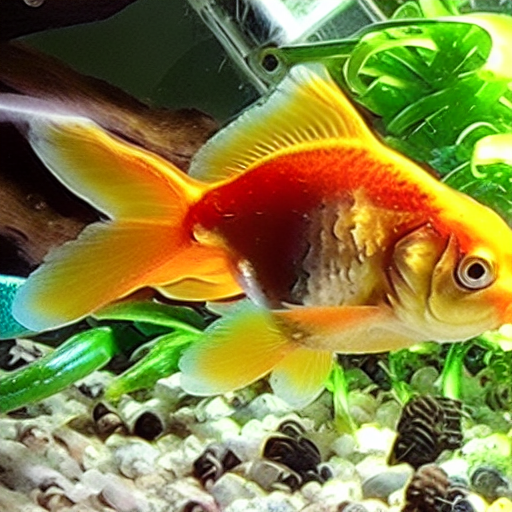

✓ Saved: /content/sd_lora_outputs/generated_images/generated_1_a_colorful_fish_swimming.png


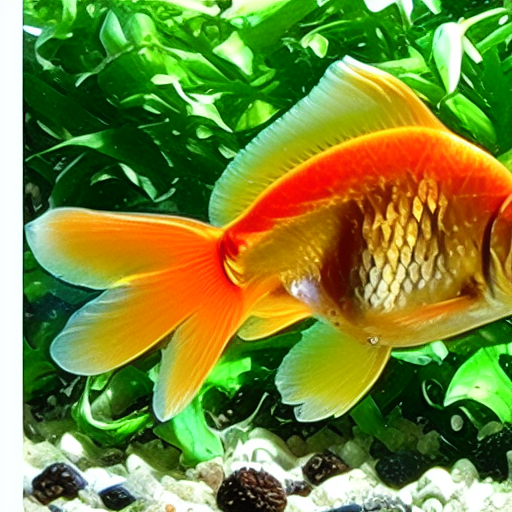

✓ Saved: /content/sd_lora_outputs/generated_images/generated_2_a_tropical_fish.png


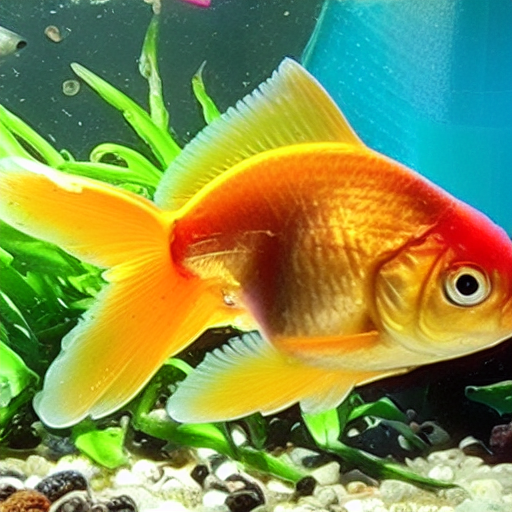

✓ Saved: /content/sd_lora_outputs/generated_images/generated_3_an_aquarium_fish.png


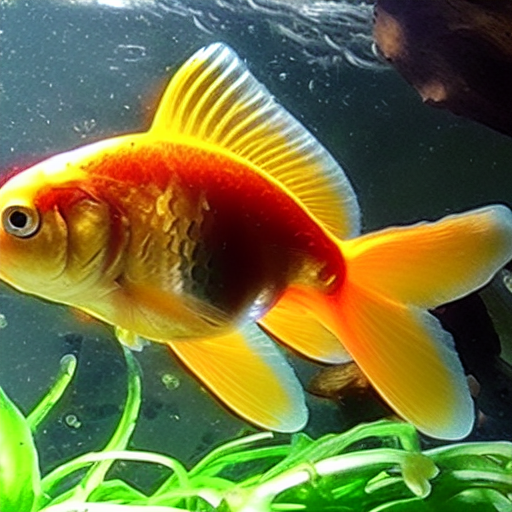


✓ All images saved to: /content/sd_lora_outputs/generated_images
POINT 1A COMPLETE: UNCONDITIONAL FISH GENERATION


In [ ]:
# ============================================================================
# CELL 10: Inference - Generate Fish Images (FIXED)
# ============================================================================
print("\n" + "="*60)
print("RUNNING INFERENCE")
print("="*60)

from diffusers import DPMSolverMultistepScheduler
from peft import PeftModel

# Create base pipeline
inference_pipeline = StableDiffusionPipeline.from_pretrained(
    config.pretrained_model_name,
    dtype=torch.float16,
)
inference_pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    inference_pipeline.scheduler.config
)

# Load LoRA weights using PEFT
print(f"Loading LoRA weights from: {best_model_path}")
inference_pipeline.unet = PeftModel.from_pretrained(
    inference_pipeline.unet,
    best_model_path,
    adapter_name="fish_lora"
)

inference_pipeline = inference_pipeline.to(device)
print("✓ Inference pipeline ready with LoRA")

# Generate fish images
prompts = [
    "a fish in aquarium",
    "a colorful fish swimming",
    "a tropical fish",
    "an aquarium fish",
]

# Optional: reduce metallic look
negative_prompts = ["metallic, shiny, reflective, mirror-like"] * len(prompts)

print(f"\nGenerating {len(prompts)} images...")

generated_images = inference_pipeline(
    prompts,
    negative_prompt=negative_prompts,
    num_inference_steps=30,
    guidance_scale=6.5,  # Reduced from 7.5 to soften metallic look
    num_images_per_prompt=1,
).images

# Save generated images
inference_output_dir = f"{config.output_dir}/generated_images"
os.makedirs(inference_output_dir, exist_ok=True)

for i, (img, prompt) in enumerate(zip(generated_images, prompts)):
    save_path = f"{inference_output_dir}/generated_{i}_{prompt.replace(' ', '_')[:30]}.png"
    img.save(save_path)
    print(f"✓ Saved: {save_path}")
    # Display in notebook
    display(img)

print(f"\n✓ All images saved to: {inference_output_dir}")
print("="*60)
print("POINT 1A COMPLETE: UNCONDITIONAL FISH GENERATION")
print("="*60)

In [ ]:
# ============================================================================
# CELL 11 (FIXED): Find and Upload Best Model
# ============================================================================

import os
import io
from googleapiclient.http import MediaIoBaseUpload
from datetime import datetime
import time

# Check what's actually in the checkpoints folder
checkpoint_dir = f"{config.output_dir}/checkpoints/lora_best.safetensors"

print("="*60)
print("FINDING BEST MODEL FILES")
print("="*60)

# List contents of the "directory"
if os.path.isdir(checkpoint_dir):
    print(f"\n✓ lora_best.safetensors is a directory. Contents:")
    for item in os.listdir(checkpoint_dir):
        item_path = os.path.join(checkpoint_dir, item)
        size = os.path.getsize(item_path) / (1024**2)
        print(f"   - {item} ({size:.2f} MB)")

    # Find the actual model file (usually adapter_model.safetensors)
    model_file = None
    for item in os.listdir(checkpoint_dir):
        if item.endswith('.safetensors') or item.endswith('.bin'):
            model_file = os.path.join(checkpoint_dir, item)
            break

    if not model_file:
        print("\n❌ No .safetensors or .bin file found in directory")
        print("Available files:")
        for item in os.listdir(checkpoint_dir):
            print(f"   - {item}")
else:
    model_file = checkpoint_dir
    print(f"\n✓ Found model file: {model_file}")

if model_file and os.path.exists(model_file):
    print(f"\n✓ Model file to upload: {model_file}")
    print(f"   Size: {os.path.getsize(model_file) / (1024**2):.2f} MB")

    # Upload function
    def upload_model_to_gdrive(model_path, max_retries=3):
        for attempt in range(max_retries):
            try:
                print(f"\n📤 Uploading model (attempt {attempt+1}/{max_retries})...")

                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = os.path.basename(model_path)
                remote_filename = f'lora_best_epoch_24_{timestamp}_{filename}'

                file_metadata = {
                    'name': remote_filename,
                    'parents': [GDRIVE_RESULTS_FOLDER_ID]
                }

                with open(model_path, 'rb') as f:
                    file_data = f.read()

                print(f"   Size: {len(file_data) / (1024**2):.2f} MB")

                media = MediaIoBaseUpload(
                    io.BytesIO(file_data),
                    mimetype='application/octet-stream',
                    resumable=True
                )

                uploaded_file = drive_service.files().create(
                    body=file_metadata,
                    media_body=media,
                    fields='id,name,webViewLink'
                ).execute()

                print(f"\n✅ Upload successful!")
                print(f"   Filename: {remote_filename}")
                print(f"   File ID: {uploaded_file.get('id')}")

                return True

            except Exception as e:
                print(f"⚠️ Attempt {attempt+1} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)
                else:
                    return False
        return False

    # Upload
    upload_model_to_gdrive(model_file)

else:
    print("\n❌ Could not find model file to upload")

print("="*60)

FINDING BEST MODEL FILES

✓ lora_best.safetensors is a directory. Contents:
   - adapter_config.json (0.00 MB)
   - adapter_model.safetensors (12.20 MB)
   - README.md (0.00 MB)

✓ Model file to upload: /content/sd_lora_outputs/checkpoints/lora_best.safetensors/adapter_model.safetensors
   Size: 12.20 MB

📤 Uploading model (attempt 1/3)...
   Size: 12.20 MB

✅ Upload successful!
   Filename: lora_best_epoch_24_20251001_162410_adapter_model.safetensors
   File ID: 1urWsuAxE3qtnHQGSSAjSiI49SPhoJc3W
